# Spatial proteomics
- Jacopo Umberto Verga

## Filtering cells by area

Filtering cells with wide areas (outliers). IQR Method:
- For each cell type
- Define .25 (Q1) and .75 quartiles (Q3)
- Define interquartile range (IQR): Q3 - Q1
- Define lower bound: Q1 - 1.5 * IQR
- Define upper bound: Q3 + 1.5 * IQR
- Filter cells with area below the lower bound or above the upper bound

Pros:
- Define thresholds specific for each cell type
- Robust to not normal distribution than standard deviation methods

Notes:
- The lower bound is likely to be negative, resulting in keeping all the cells below the upper limit

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read('../data/non_denoised/spe_minor_celltypes_clean_20240626-142029.h5ad')

In [3]:
df=adata.obs[['major_cell_type','minor_cell_type','area']]

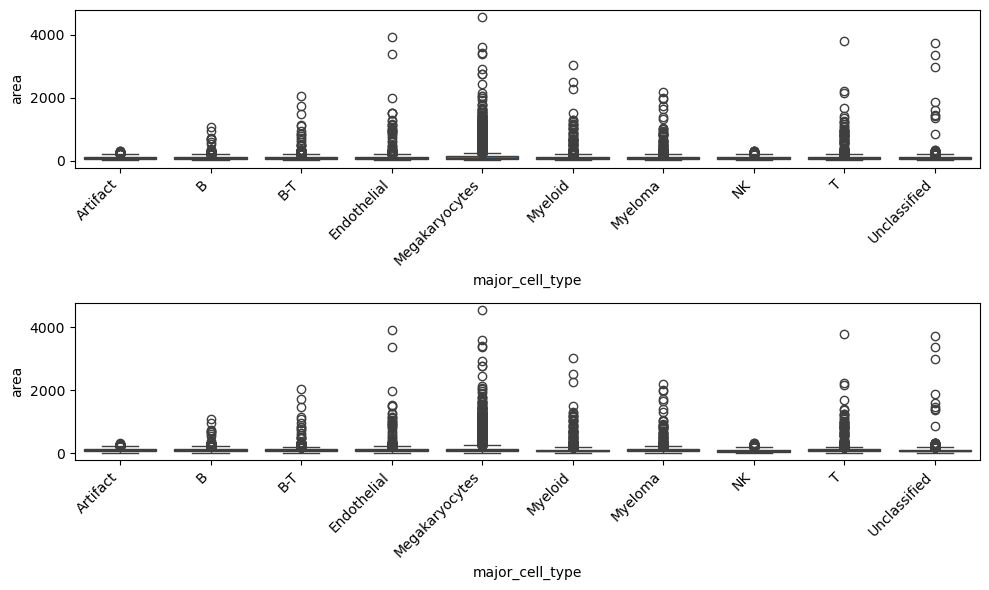

In [4]:
fig, axes = plt.subplots(2,1,figsize=(10,6))
sns.boxplot(data=df, x='major_cell_type',y='area',ax=axes[0])
# Rotate and align the x-tick labels
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')


sns.boxplot(data=df, x='major_cell_type',y='area',ax=axes[1])
# Rotate and align the x-tick labels
for label in axes[1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

In [5]:
df.pivot(columns='major_cell_type',values='area').describe()

major_cell_type,Artifact,B,B-T,Endothelial,Megakaryocytes,Myeloid,Myeloma,NK,T,Unclassified
count,5123.000000,17865.000000,52069.000000,13604.000000,9313.000000,247651.000000,63826.000000,6265.000000,84123.000000,14501.000000
mean,98.350185,94.115477,91.954656,96.670832,126.763986,88.026796,95.059647,80.346049,91.470383,85.223571
std,47.777300,49.242937,47.743476,77.726031,181.536762,46.854982,51.689761,47.120538,52.050114,70.342231
min,8.000000,8.000000,8.000000,8.000000,7.000000,6.000000,7.000000,8.000000,8.000000,6.000000
25%,63.000000,59.000000,59.000000,58.000000,62.000000,54.000000,60.000000,44.000000,58.000000,52.000000
50%,91.000000,86.000000,85.000000,86.000000,92.000000,80.000000,88.000000,71.000000,84.000000,77.000000
75%,126.000000,121.000000,118.000000,123.000000,134.000000,113.000000,123.000000,107.000000,117.000000,109.000000
max,313.000000,1074.000000,2048.000000,3916.000000,4555.000000,3020.000000,2190.000000,311.000000,3793.000000,3720.000000


In [6]:
df.pivot(columns='minor_cell_type',values='area').describe()

minor_cell_type,Artifact,B,B mem,B unk,B-T,CD4 Tem,CD4 Temra,CD4 Th17,CD4 Tmem,CD4 Tnaive,...,Intermediate Monocytes,Macrophages,Macrophages-CD163 neg,Macrophages-hla,Megakaryocytes,Myeloma,Non Classical Monocytes,Other myeloid,T lineage,Unclassified
count,5123.000000,2685.000000,8534.000000,6499.000000,52216.000000,5976.000000,2424.000000,2429.000000,16162.000000,4819.000000,...,9585.000000,22427.000000,2642.000000,24336.000000,9313.000000,63826.000000,40697.000000,119505.000000,6058.000000,14501.000000
mean,98.350185,89.264060,95.125498,94.072011,92.050540,84.427041,68.380363,89.545080,101.620344,87.439303,...,93.490662,95.878093,88.082135,91.077909,126.763986,95.059647,95.891270,81.794402,78.112413,85.223571
std,47.777300,52.332466,48.610004,48.344085,47.789777,44.281073,42.413425,61.245779,51.658920,42.322952,...,51.906965,48.364205,61.400225,47.702584,181.536762,51.689761,48.008976,44.352664,49.874451,70.342231
min,8.000000,9.000000,8.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,...,6.000000,8.000000,8.000000,8.000000,7.000000,7.000000,8.000000,7.000000,8.000000,6.000000
25%,63.000000,54.000000,59.000000,60.000000,59.000000,54.000000,36.000000,54.000000,66.000000,56.000000,...,59.000000,59.000000,54.000000,55.000000,62.000000,60.000000,61.000000,51.000000,42.000000,52.000000
50%,91.000000,80.000000,87.000000,87.000000,85.000000,79.000000,62.000000,82.000000,94.000000,81.000000,...,86.000000,88.000000,80.000000,83.000000,92.000000,88.000000,88.000000,74.000000,69.000000,77.000000
75%,126.000000,114.000000,123.000000,120.000000,118.000000,108.000000,91.000000,115.000000,129.000000,112.000000,...,121.000000,125.000000,113.000000,118.000000,134.000000,123.000000,123.000000,104.000000,105.000000,109.000000
max,313.000000,954.000000,731.000000,1074.000000,2048.000000,1017.000000,283.000000,1683.000000,1416.000000,286.000000,...,2501.000000,852.000000,2266.000000,1218.000000,4555.000000,2190.000000,1146.000000,3020.000000,974.000000,3720.000000


In [7]:
def iqr_thresholds(df,celltype):
    Q1 = df['area'].quantile(0.25)
    Q3 = df['area'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    upper_diameter = round(np.sqrt(upper_bound/np.pi)*2,2)
    print(f"{celltype}:\n\
    median: {df['area'].median()}\n\
    IQR: {IQR}\n\
    lower bound (negative): {lower_bound}\n\
    upper bound: {upper_bound}\n\
    max diameter (circle): {upper_diameter}um")
    return lower_bound, upper_bound


def filter_thresholds(df, lower_bound, upper_bound):
    df_filtered = df[(df['area'] > lower_bound) & (df['area'] < upper_bound)]
    return df_filtered

def plot_distributions(df,df_filtered,celltype):
    fig,axes=plt.subplots(2,1)
    sns.histplot(df['area'], bins=100,ax=axes[0])
    axes[0].set_title('unfiltered')
    sns.histplot(df_filtered['area'],ax=axes[1])
    axes[1].set_title('filtered')
    plt.suptitle(celltype)
    plt.tight_layout()
    plt.show()


def set_threshold_plot(df, celltype):
    lower_bound, upper_bound = iqr_thresholds(df,celltype)
    df_filtered=filter_thresholds(df, lower_bound, upper_bound)
    plot_distributions(df,df_filtered,celltype)
    return df_filtered

def filter_adata(adata, df, df_filtered):
    index_to_remove = list(set(df.index) - set(df_filtered.index))
    adata=adata[~adata.obs_names.isin(index_to_remove)]
    return adata

# B cells

B cells:
    median: 86.0
    IQR: 62.0
    lower bound (negative): -34.0
    upper bound: 214.0
    max diameter (circle): 16.51um


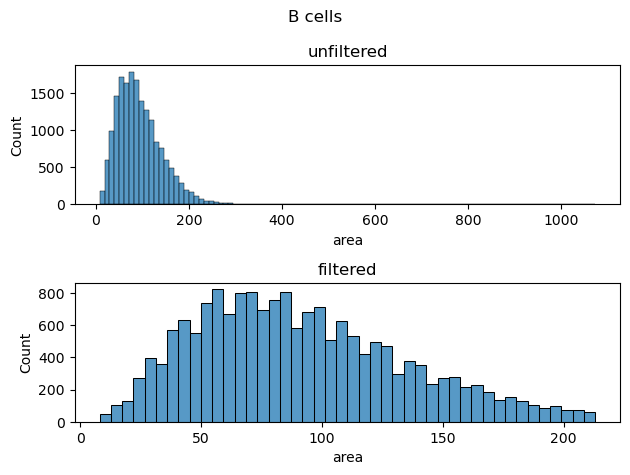

In [8]:
cell='B'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [9]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 514014 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## Endothelial

Endothelial cells:
    median: 86.0
    IQR: 65.0
    lower bound (negative): -39.5
    upper bound: 220.5
    max diameter (circle): 16.76um


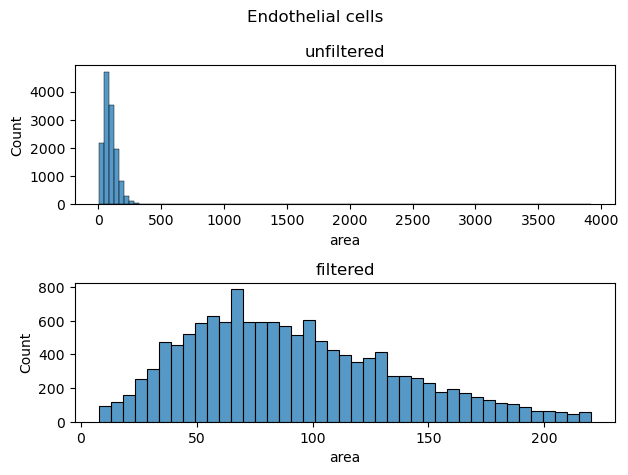

In [10]:
cell='Endothelial'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [11]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 513715 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## Myeloid

Myeloid cells:
    median: 80.0
    IQR: 59.0
    lower bound (negative): -34.5
    upper bound: 201.5
    max diameter (circle): 16.02um


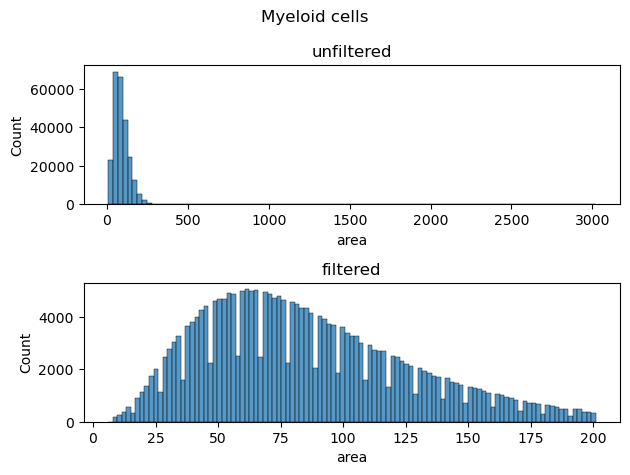

In [12]:
cell='Myeloid'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [13]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 508559 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## Myeloma

Myeloma cells:
    median: 88.0
    IQR: 63.0
    lower bound (negative): -34.5
    upper bound: 217.5
    max diameter (circle): 16.64um


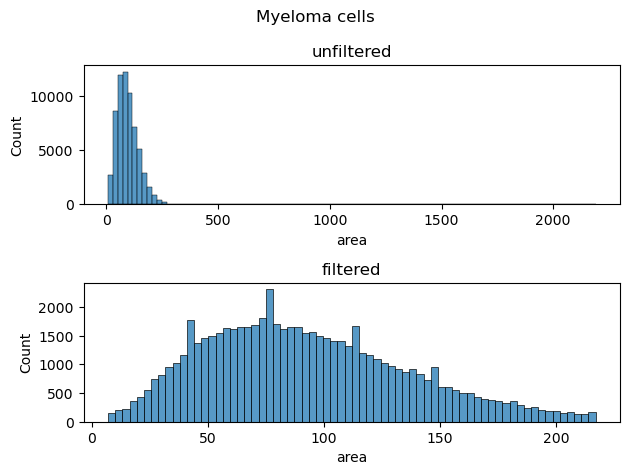

In [14]:
cell='Myeloma'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [15]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 507608 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## NK

NK cells:
    median: 71.0
    IQR: 63.0
    lower bound (negative): -50.5
    upper bound: 201.5
    max diameter (circle): 16.02um


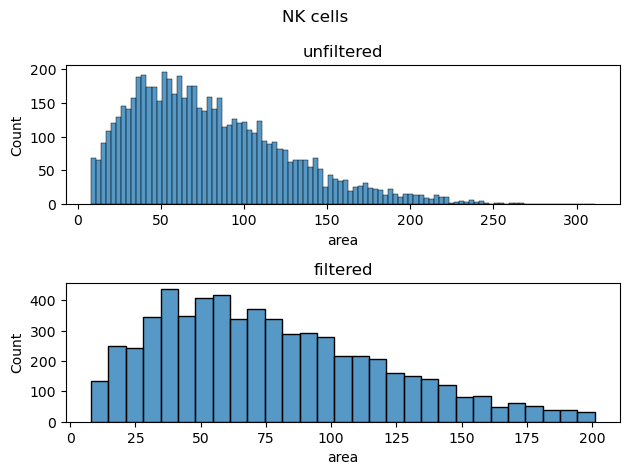

In [16]:
cell='NK'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [17]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 507481 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## T

T cells:
    median: 84.0
    IQR: 59.0
    lower bound (negative): -30.5
    upper bound: 205.5
    max diameter (circle): 16.18um


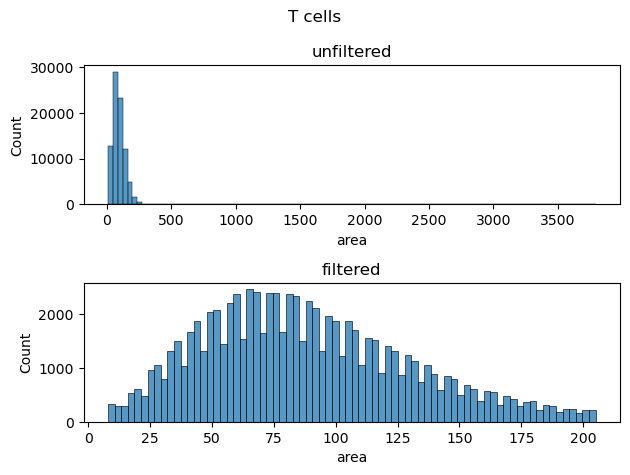

In [18]:
cell='T'
df_tmp=df[df['major_cell_type'] == cell]

df_tmp_filtered=set_threshold_plot(df_tmp,cell + ' cells')

In [19]:
adata=filter_adata(adata, df_tmp, df_tmp_filtered)
adata

View of AnnData object with n_obs × n_vars = 505794 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## Plot filtered areas

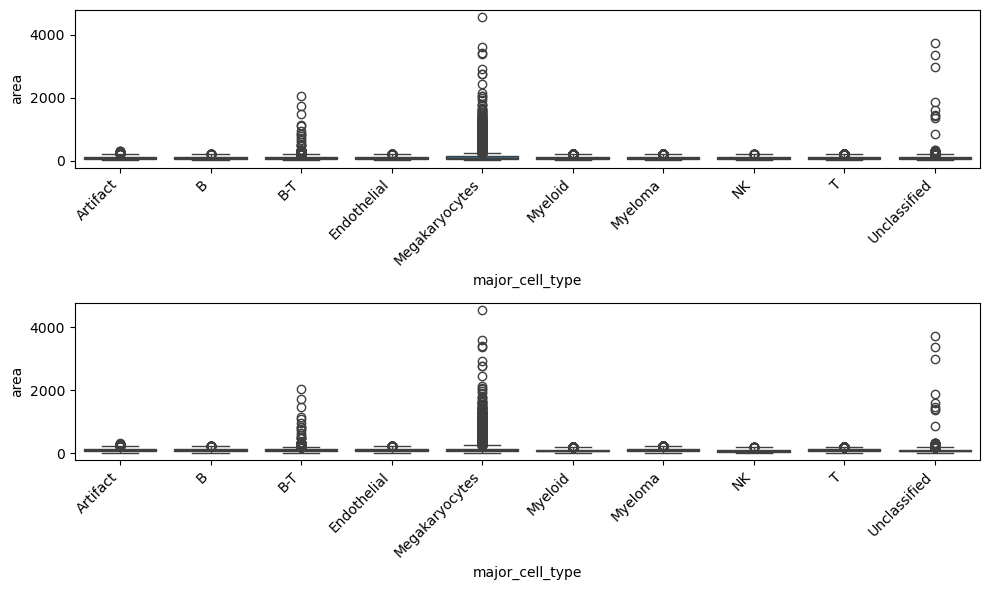

In [20]:
df=adata.obs[['major_cell_type','minor_cell_type','area']]

fig, axes = plt.subplots(2,1,figsize=(10,6))
sns.boxplot(data=df, x='major_cell_type',y='area',ax=axes[0])
# Rotate and align the x-tick labels
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')


sns.boxplot(data=df, x='major_cell_type',y='area',ax=axes[1])
# Rotate and align the x-tick labels
for label in axes[1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

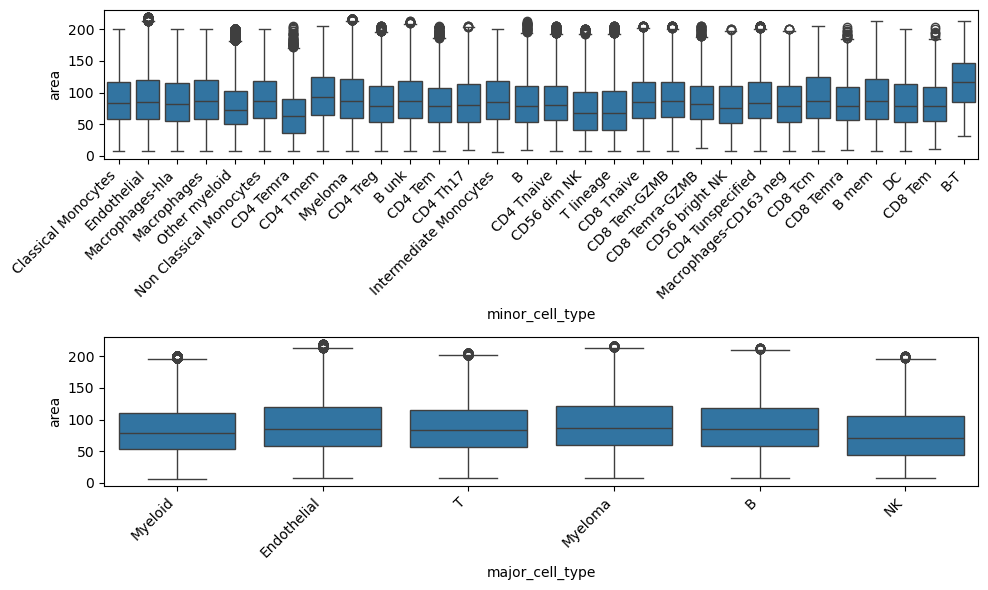

In [21]:
df['major_cell_type'] = df['major_cell_type'].astype('str')
df['minor_cell_type'] = df['minor_cell_type'].astype('str')

df= df[~df['major_cell_type'].isin(['Artifact','B-T','Megakaryocytes','Unclassified'])]

fig, axes = plt.subplots(2,1,figsize=(10,6))
sns.boxplot(data=df, x='minor_cell_type',y='area',ax=axes[0])
# Rotate and align the x-tick labels
for label in axes[0].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')


sns.boxplot(data=df, x='major_cell_type',y='area',ax=axes[1])
# Rotate and align the x-tick labels
for label in axes[1].get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()
plt.show()

In [22]:
filename = '../data/non_denoised/spe_minor_celltypes_clean_'+ time.strftime("%Y%m%d-%H%M%S") + '.h5ad'

In [23]:
print(filename)

../data/non_denoised/spe_minor_celltypes_clean_20240626-154422.h5ad


In [ ]:
adata.write(filename)